# Data preparation example

In [ ]:
!gdown -q --fuzzy https://drive.google.com/file/d/1j3r6y3CZaessmzB492eMMW8TM3-W7E5m/view?usp=sharing -O 000.nrrd

In [ ]:
!gdown -q --fuzzy https://drive.google.com/file/d/19ATVoTxAVHhcFwyw_28Qj3ugA-g-dJTu/view?usp=sharing -O 000_defective.nrrd

In [ ]:
!gdown -q --fuzzy https://drive.google.com/file/d/1YG91dGMMM-QBMKk0wHj2EfzH2YpKzMEv/view?usp=sharing -O classification_template.nii.gz

In [ ]:
!pip install -q torchio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 5.3 MB/s eta 0:00:00


### Convert Skullbreak NRRD to NifTI format

ScalarImage(shape: (1, 512, 512, 512); spacing: (0.40, 0.40, 0.40); orientation: RAS+; dtype: torch.ByteTensor; memory: 128.0 MiB)


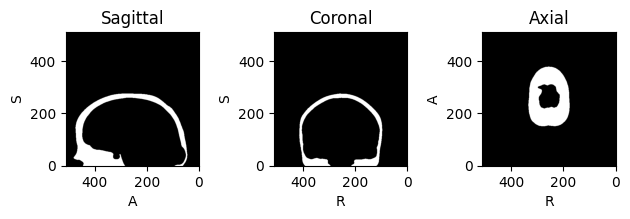

ScalarImage(shape: (1, 512, 512, 512); spacing: (0.40, 0.40, 0.40); orientation: RAS+; dtype: torch.ByteTensor; memory: 128.0 MiB)


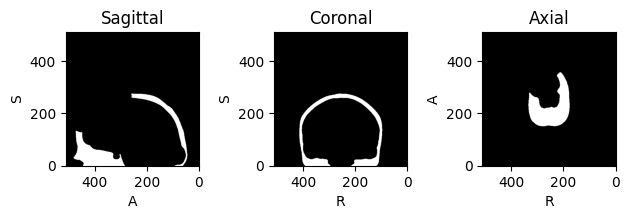

ScalarImage(shape: (1, 512, 512, 512); spacing: (0.40, 0.40, 0.40); orientation: RAS+; dtype: torch.ByteTensor; memory: 128.0 MiB)

In [ ]:
import torchio as tio


def convert_nrrd_to_nifti(filename, verbose=False, outfile=True):
    ras = tio.ToCanonical()
    img = tio.ScalarImage(filename)
    img = ras(img)
    if verbose:
        print(img)
        img.plot()
    if outfile:
        img.save(filename.replace('.nrrd', '.nii.gz'))

    return img

convert_nrrd_to_nifti('000.nrrd',verbose=True)
convert_nrrd_to_nifti('000_defective.nrrd',verbose=True)

### Skull categorization

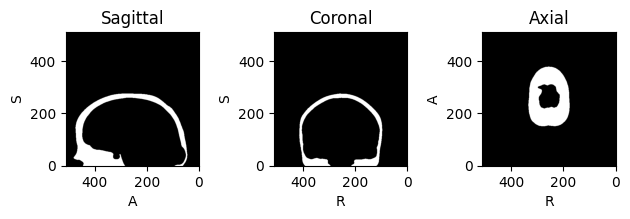

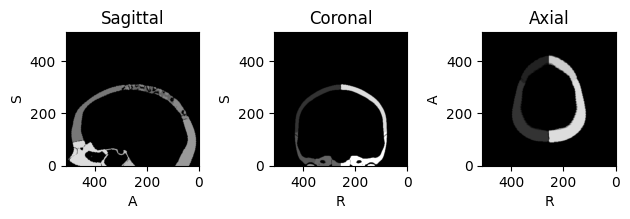

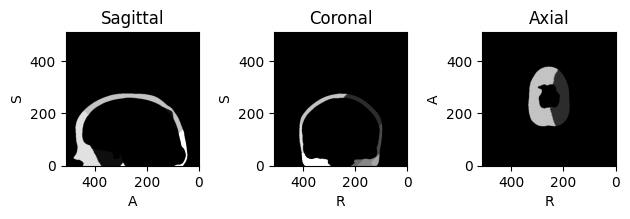

In [ ]:
import torchio as tio
from skimage.morphology import dilation


def categorize_skull(filename, categorized_template, dilate_pixel=40, outfile=True, verbose=False):
    img = tio.ScalarImage(filename)
    template = tio.ScalarImage(categorized_template)
    if verbose:
        img.plot()
        template.plot()
    for _ in range(dilate_pixel):
        template.set_data(dilation(template.data))
    img.set_data(img.data * template.data | img.data)
    if verbose:
        img.plot()
    if outfile:
        img.save(filename.replace('.nii.gz', '_categorized.nii.gz'))
    return img

img = categorize_skull('000.nii.gz','classification_template.nii.gz', verbose=True)

# CraNeXt example

### Model architecture

In [ ]:
import torch
from model import CraNeXt

model = CraNeXt()

### Pre-trained model example

In [ ]:
# CraNeXt model, pretrained with SkullBreak
!gdown -q --fuzzy https://drive.google.com/file/d/1Dnz-wCC1JP37WN7oh_I_acJChEVG7q5A/view?usp=sharing -O CraNeXt_pretrained.pth

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('CraNeXt_pretrained.pth',map_location=device))

<All keys matched successfully>

### Pre-trained model testing

In [ ]:
!pip install -q monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.4 MB/s eta 0:00:00


In [ ]:
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    ToDeviced,
    Orientationd,
    Resized,
    RandFlipd,
    EnsureTyped,
    Invertd,
    AsDiscreted,
)

from monai.data import DataLoader, Dataset, decollate_batch

def merge_batch(batch_pred: list, post_pred: Compose):
    post_pred_batch = [post_pred(i) for i in decollate_batch(batch_pred)]
    pred_img = post_pred_batch[0]["pred"][0, :, :, :].detach().cpu().numpy()
    return pred_img

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transforms = Compose([
    LoadImaged(keys="image",ensure_channel_first=True,image_only=True,dtype=torch.float),
    Orientationd(keys="image", axcodes="RAS"),
    ToDeviced(keys="image", device=device),
    CropForegroundd(keys="image", source_key="image", margin=25, allow_smaller=False),
    Resized(keys="image",spatial_size=(176, 224, 144),mode="area"),
    EnsureTyped(keys="image", dtype=torch.float, device=device),
])

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", threshold=0.5),
])

post_pred = Compose([AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(to_onehot=2)])

test_files = [{'image':'000_defective.nii.gz'}]

test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds)

model.eval()
with torch.no_grad():
    for batch_data in test_loader:
        inputs = batch_data["image"].to(device)
        batch_data["pred"] = model(inputs)
        bd = [x for x in decollate_batch(batch_data)]
        image_output = merge_batch(batch_data, post_transforms)

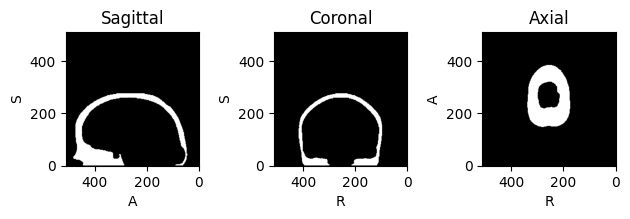

In [ ]:
import torchio as tio
import numpy as np

output = tio.ScalarImage(tensor=np.array([image_output]))
output.plot()
output.save('000_predicted.nii.gz')

# Evaluation example

In [ ]:
!pip install -q medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### Post-processing

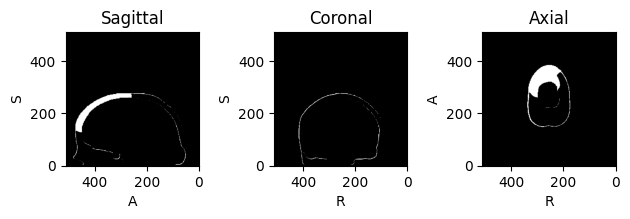

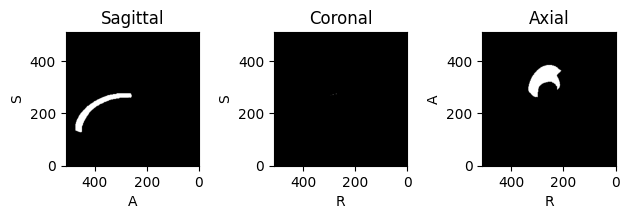

In [ ]:
import torchio as tio
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation
from skimage.measure import label

def largest_connected_component(data):
    labels = label(data)
    largest_cc = labels == np.argmax(np.bincount(labels.flat, weights=data.flat))
    return largest_cc

gt = tio.ScalarImage('000.nii.gz')
inpt = tio.ScalarImage('000_defective.nii.gz')
pred = tio.ScalarImage('000_predicted.nii.gz')

gt_implant = tio.ScalarImage(tensor=gt.data-inpt.data)
gt_implant.save('000_implant.nii.gz')

implant = tio.ScalarImage(tensor=pred.data-inpt.data)
implant.plot()

implant_data = implant.data

implant_data = binary_erosion(implant_data).astype(int)
implant_data = binary_erosion(implant_data).astype(int)
implant_data = largest_connected_component(implant_data[0])
implant_data = binary_dilation(implant_data).astype(int)
implant_data = binary_dilation(implant_data).astype(int)

implant.set_data(np.array([implant_data]))
implant.plot()

implant.save('000_predicted_implant.nii.gz')


### Evaluate predicted implant

In [ ]:
from medpy.metric.binary import hd,hd95
import torchio as tio


gt_implant = tio.ScalarImage('000_implant.nii.gz').data.numpy()[0].astype(np.uint8)
implant = tio.ScalarImage('000_predicted_implant.nii.gz').data.numpy()[0].astype(np.uint8)
spacing=(0.4,0.4,0.4)

print('dH:', hd(implant,gt_implant,voxelspacing=spacing))
print('dH95:', hd95(implant,gt_implant,voxelspacing=spacing))

dH: 3.298484500494129
dH95: 1.2000000000000002


### Surface Hausdorff

In [ ]:
import numpy as np
from medpy.metric.binary import hd
from shd_metric import extract_implant_surface, shd

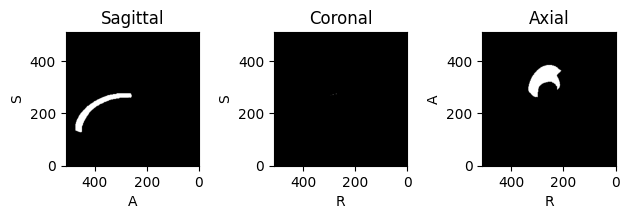

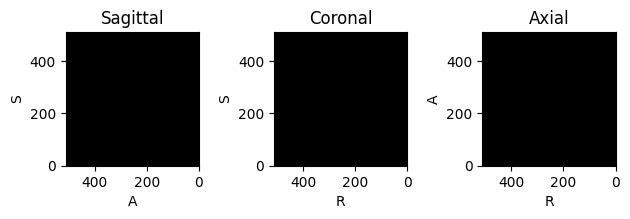

In [ ]:
ras = tio.ToCanonical()

implant = ras(tio.ScalarImage('000_predicted_implant.nii.gz'))
implant.plot()

surface = extract_implant_surface(implant.data.numpy()[0].astype(np.uint8))
surface = tio.ScalarImage(tensor=np.array([surface]))
surface.plot()